<a href="https://colab.research.google.com/github/Ayaz-75/Medical-Image-Classification-using-CNNs-Detecting-Pneumonia-from-Chest-X-rays/blob/main/pneumonia_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Classification: Pneumonia Detection from Chest X-rays
This Colab notebook trains a simple CNN to classify chest X-rays as **Normal** vs **Pneumonia** using the Kaggle dataset.

In [ ]:
# Run this cell first to ensure required packages are available
!pip install -q kaggle
!pip install -q tensorflow==2.14.1   # or latest TF available in Colab
!pip install -q seaborn opencv-python-headless

ERROR: Could not find a version that satisfies the requirement tensorflow==2.14.1 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.14.1


In [ ]:
from google.colab import files
import os
import zipfile
import shutil

# Upload kaggle.json
print("Upload your kaggle.json (Kaggle API token).")
uploaded = files.upload()  # select kaggle.json from your computer

# Create Kaggle folder & move token
os.makedirs('/root/.kaggle', exist_ok=True)
for fn in uploaded:
    open('/root/.kaggle/kaggle.json', 'wb').write(uploaded[fn])
os.chmod('/root/.kaggle/kaggle.json', 0o600)

# Download dataset (Kaggle dataset: paultimothymooney/chest-xray-pneumonia)
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content --unzip

# The zip will extract into /content/chest_xray
!ls -la /content/chest_xray

Upload your kaggle.json (Kaggle API token).


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:25<00:00, 271MB/s]
100% 2.29G/2.29G [00:25<00:00, 96.4MB/s]
total 28
drwxr-xr-x 7 root root 4096 Nov  7 07:00 .
drwxr-xr-x 1 root root 4096 Nov  7 07:00 ..
drwxr-xr-x 5 root root 4096 Nov  7 06:59 chest_xray
drwxr-xr-x 3 root root 4096 Nov  7 06:59 __MACOSX
drwxr-xr-x 4 root root 4096 Nov  7 06:59 test
drwxr-xr-x 4 root root 4096 Nov  7 07:00 train
drwxr-xr-x 4 root root 4096 Nov  7 07:00 val


In [ ]:
import os

data_dir = '/content/chest_xray'   # default Kaggle path after unzipping
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"{data_dir} not found. Make sure you extracted or downloaded the dataset.")

def count_images(base):
    for split in ['train','val','test']:
        split_dir = os.path.join(base, split)
        if os.path.exists(split_dir):
            n_normal = len(os.listdir(os.path.join(split_dir,'NORMAL'))) if os.path.exists(os.path.join(split_dir,'NORMAL')) else 0
            n_pneu = len(os.listdir(os.path.join(split_dir,'PNEUMONIA'))) if os.path.exists(os.path.join(split_dir,'PNEUMONIA')) else 0
            print(f"{split}: NORMAL={n_normal}, PNEUMONIA={n_pneu}")
        else:
            print(f"{split} folder not found.")

count_images(data_dir)


train: NORMAL=1341, PNEUMONIA=3875
val: NORMAL=8, PNEUMONIA=8
test: NORMAL=234, PNEUMONIA=390


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Use GPU if available
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: []


In [ ]:
# Set up directories
train_dir = '/content/chest_xray/train'
val_dir   = '/content/chest_xray/val'   # may or may not exist in the dataset
test_dir  = '/content/chest_xray/test'

IMG_SIZE = (150,150)   # small for Colab; increase if you have more GPU memory
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# If val folder exists, use it; otherwise use test as validation (less ideal)
if os.path.exists(val_dir):
    val_generator = test_datagen.flow_from_directory(
        val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)
else:
    val_generator = test_datagen.flow_from_directory(
        test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
def build_simple_cnn(input_shape=(150,150,3)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 74, 74, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,377 (18.42 MB)

 Trainable params: 4,828,929 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Callbacks
checkpoint_path = '/content/model_checkpoint.h5'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')
]

EPOCHS = 10   # small for demo; increase to 20-30 for better performance

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8537 - loss: 0.3986

163/163 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.8539 - loss: 0.3979 - val_accuracy: 0.5000 - val_loss: 6.7083
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.9165 - loss: 0.2071 - val_accuracy: 0.5000 - val_loss: 7.3610
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9393 - loss: 0.1680

163/163 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9393 - loss: 0.1681 - val_accuracy: 0.5000 - val_loss: 4.4368
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9406 - loss: 0.1644

163/163 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.9406 - loss: 0.1643 - val_accuracy: 0.5625 - val_loss: 1.4230
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9514 - loss: 0.1458

163/163 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.9514 - loss: 0.1458 - val_accuracy: 0.6875 - val_loss: 0.6367
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9457 - loss: 0.1390 - val_accuracy: 0.7500 - val_loss: 0.6747
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9476 - loss: 0.1339

163/163 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9476 - loss: 0.1339 - val_accuracy: 0.8125 - val_loss: 0.5207
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9524 - loss: 0.1359

163/163 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9524 - loss: 0.1359 - val_accuracy: 0.8125 - val_loss: 0.5069
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9516 - loss: 0.1272

163/163 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9516 - loss: 0.1271 - val_accuracy: 0.8125 - val_loss: 0.4415
Epoch 10/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9570 - loss: 0.1183 - val_accuracy: 0.5625 - val_loss: 1.0104


FileNotFoundError: [Errno 2] No such file or directory: '/content/results/training_curves.png'

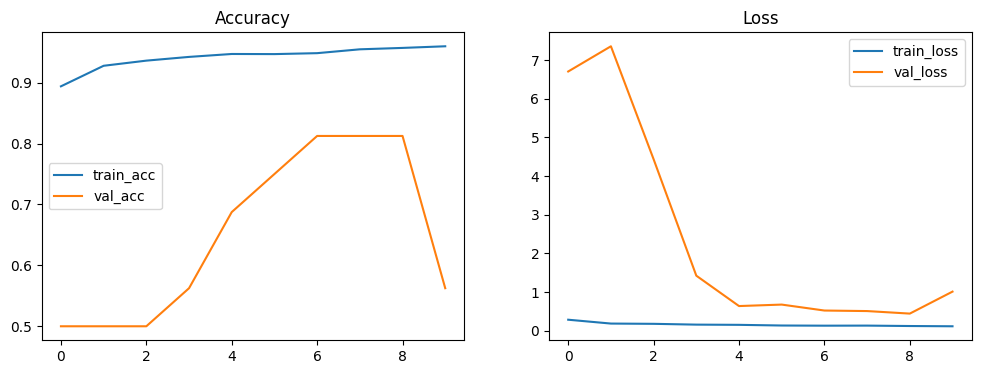

In [ ]:
# Plot accuracy & loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.savefig('/content/results/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 868ms/step


FileNotFoundError: [Errno 2] No such file or directory: '/content/results/confusion_matrix.png'

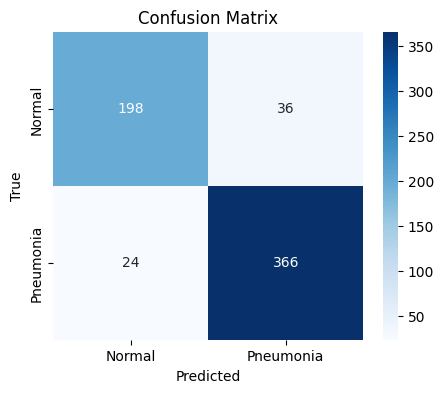

In [ ]:
# Predict on test set
test_steps = test_generator.samples // test_generator.batch_size + 1
y_prob = model.predict(test_generator, steps=test_steps)
y_pred = (y_prob > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes[:len(y_pred)]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Pneumonia'], yticklabels=['Normal','Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/content/results/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=['Normal','Pneumonia']))

# ROC-AUC (if applicable)
try:
    auc = roc_auc_score(y_true, y_prob[:len(y_true)])
    print("ROC AUC:", auc)
except Exception as e:
    print("ROC AUC not computed:", e)

# Save model
model.save('/content/results/pneumonia_cnn_model.h5')
print("Model saved to /content/results/pneumonia_cnn_model.h5")


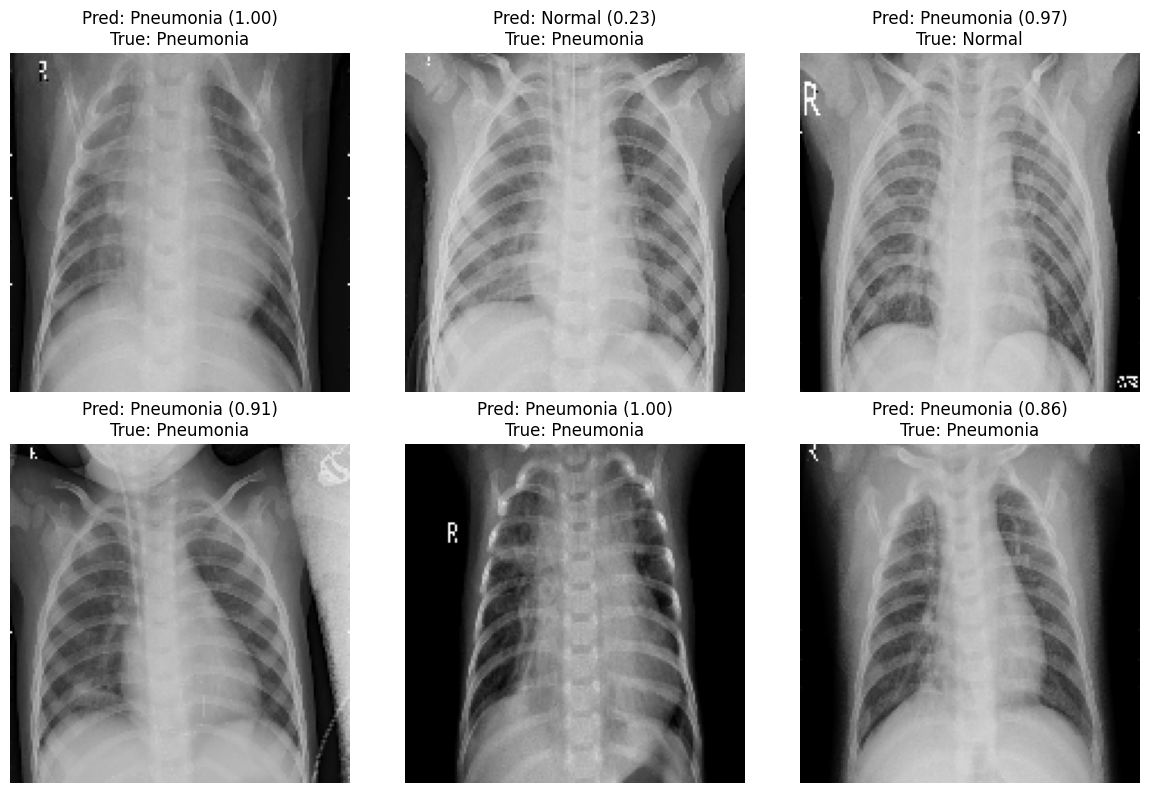

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image

# show some predictions
filenames = test_generator.filenames
indices_to_show = np.random.choice(len(y_pred), size=6, replace=False)

plt.figure(figsize=(12,8))
for i, idx in enumerate(indices_to_show):
    img_path = os.path.join(test_dir, filenames[idx])
    img = image.load_img(img_path, target_size=IMG_SIZE)
    arr = image.img_to_array(img) / 255.0
    pred_prob = y_prob[idx][0]
    pred_label = "Pneumonia" if pred_prob > 0.5 else "Normal"
    true_label = "Pneumonia" if y_true[idx] == 1 else "Normal"
    plt.subplot(2,3,i+1)
    plt.imshow(arr)
    plt.title(f"Pred: {pred_label} ({pred_prob:.2f})\nTrue: {true_label}")
    plt.axis('off')
plt.tight_layout()
